In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
import json
kaggle_credentails = json.load(open("/content/kaggle_.json"))

In [4]:
import os

# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]


!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 328M/331M [00:09<00:00, 33.0MB/s]
100% 331M/331M [00:09<00:00, 36.0MB/s]


In [5]:
!ls

kaggle_.json  sample_data  utkface-new.zip


In [7]:
from zipfile import ZipFile

In [8]:
# Unzip the downloaded dataset
with ZipFile("/content/utkface-new.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [9]:
BASE_DIR = '/content/UTKFace'

In [10]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/9_0_0_20170110220312322.jpg.c...,9,0
1,/content/UTKFace/51_0_1_20170113142122196.jpg....,51,0
2,/content/UTKFace/31_0_3_20170104220255896.jpg....,31,0
3,/content/UTKFace/60_1_0_20170110131522551.jpg....,60,1
4,/content/UTKFace/48_0_3_20170119192924313.jpg....,48,0


In [12]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

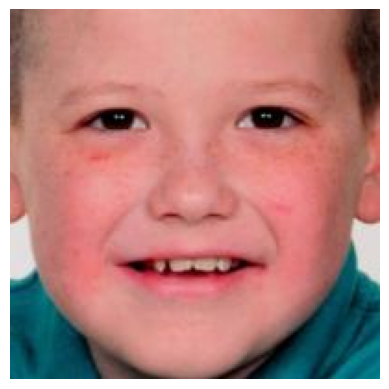

In [16]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

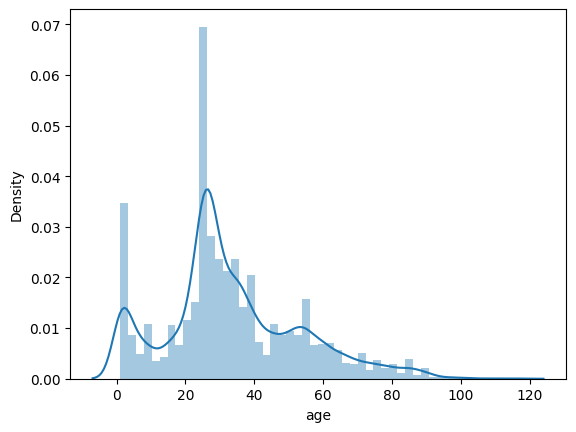

In [17]:
sns.distplot(df['age'])

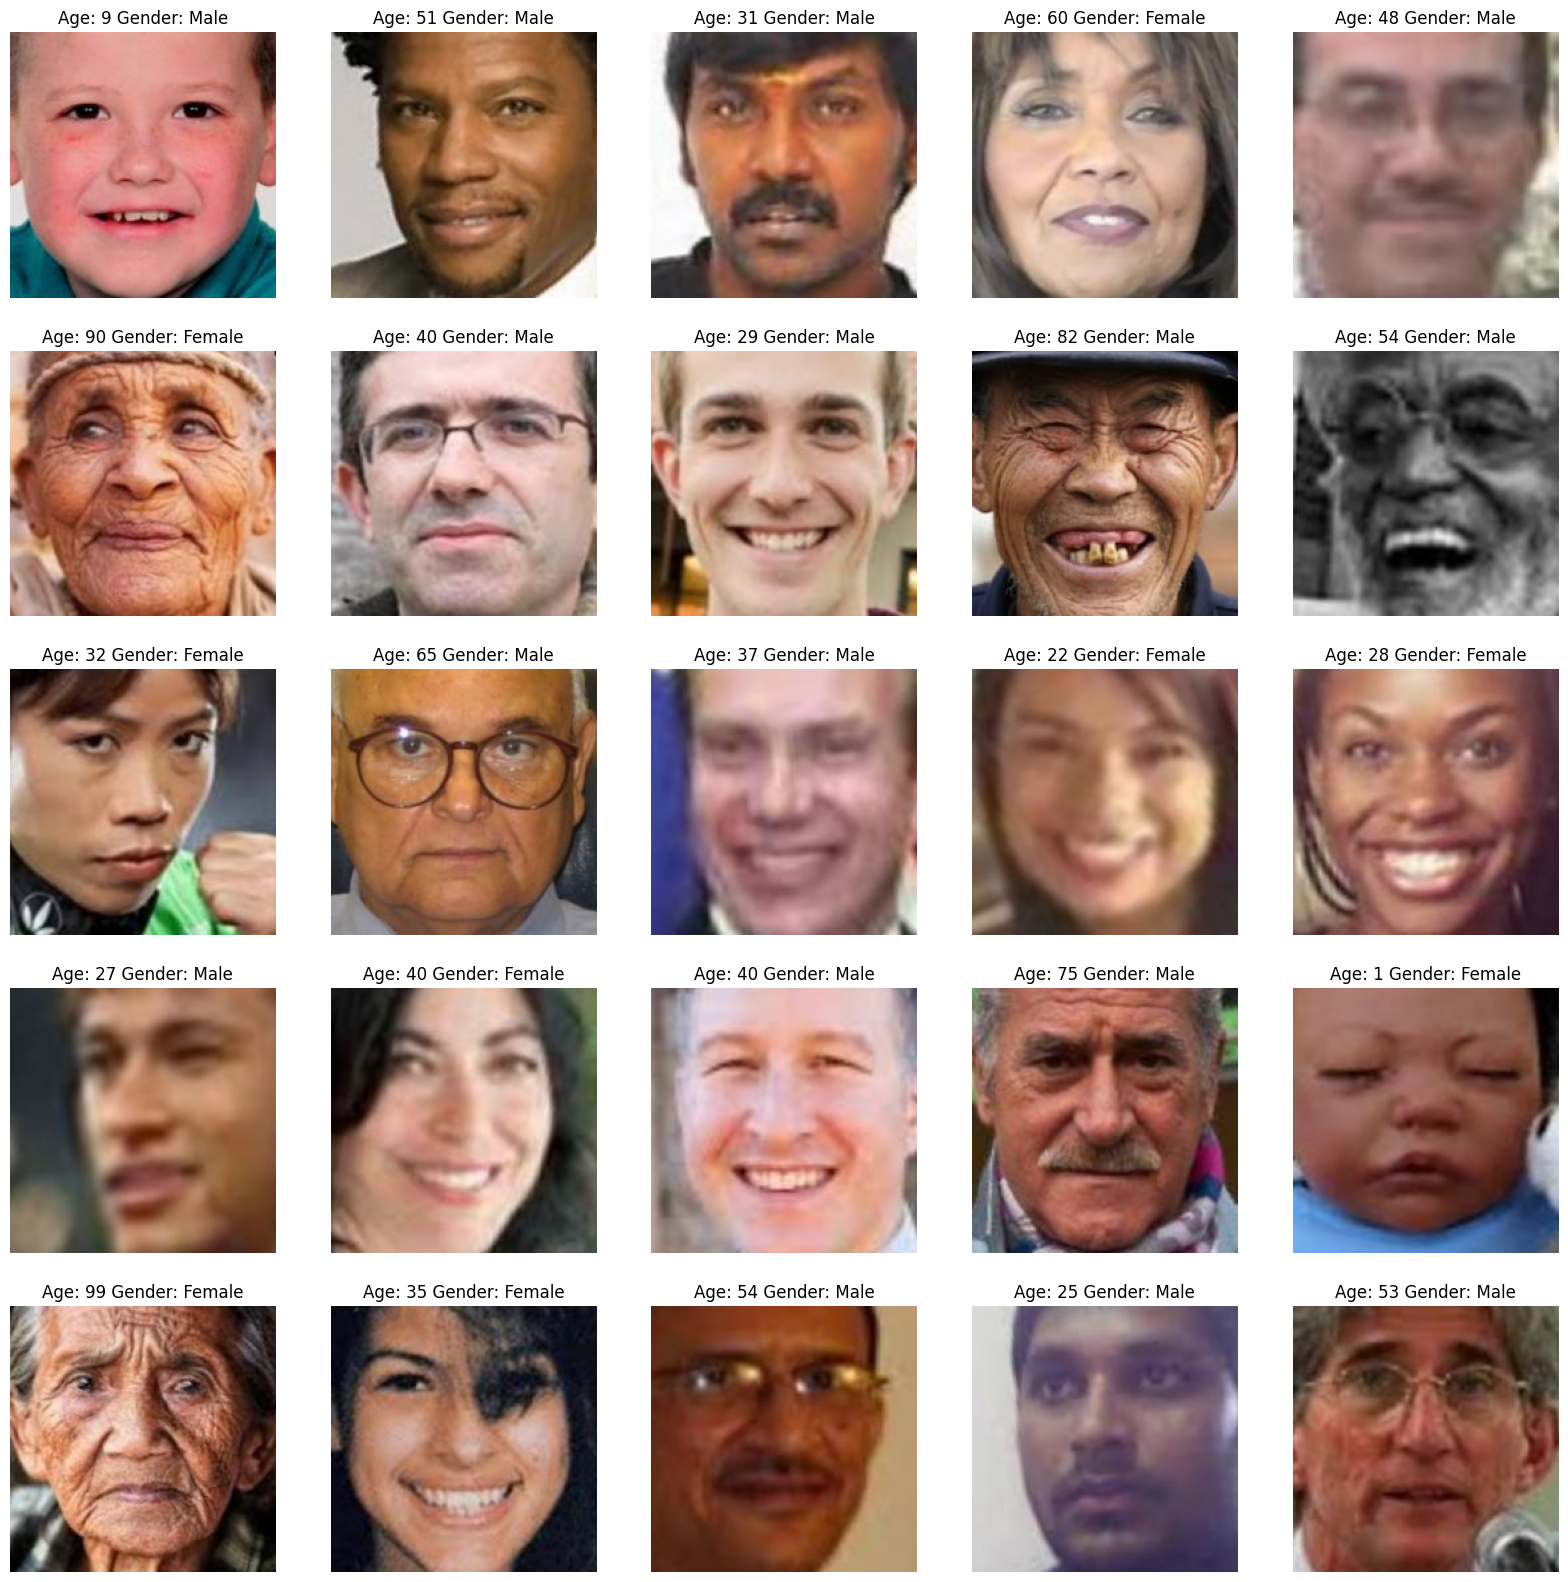

In [20]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [21]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [22]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [23]:
X.shape

(23708, 128, 128, 1)

In [24]:
# normalize the images
X = X/255.0

In [25]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [26]:
input_shape = (128, 128, 1)

In [28]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

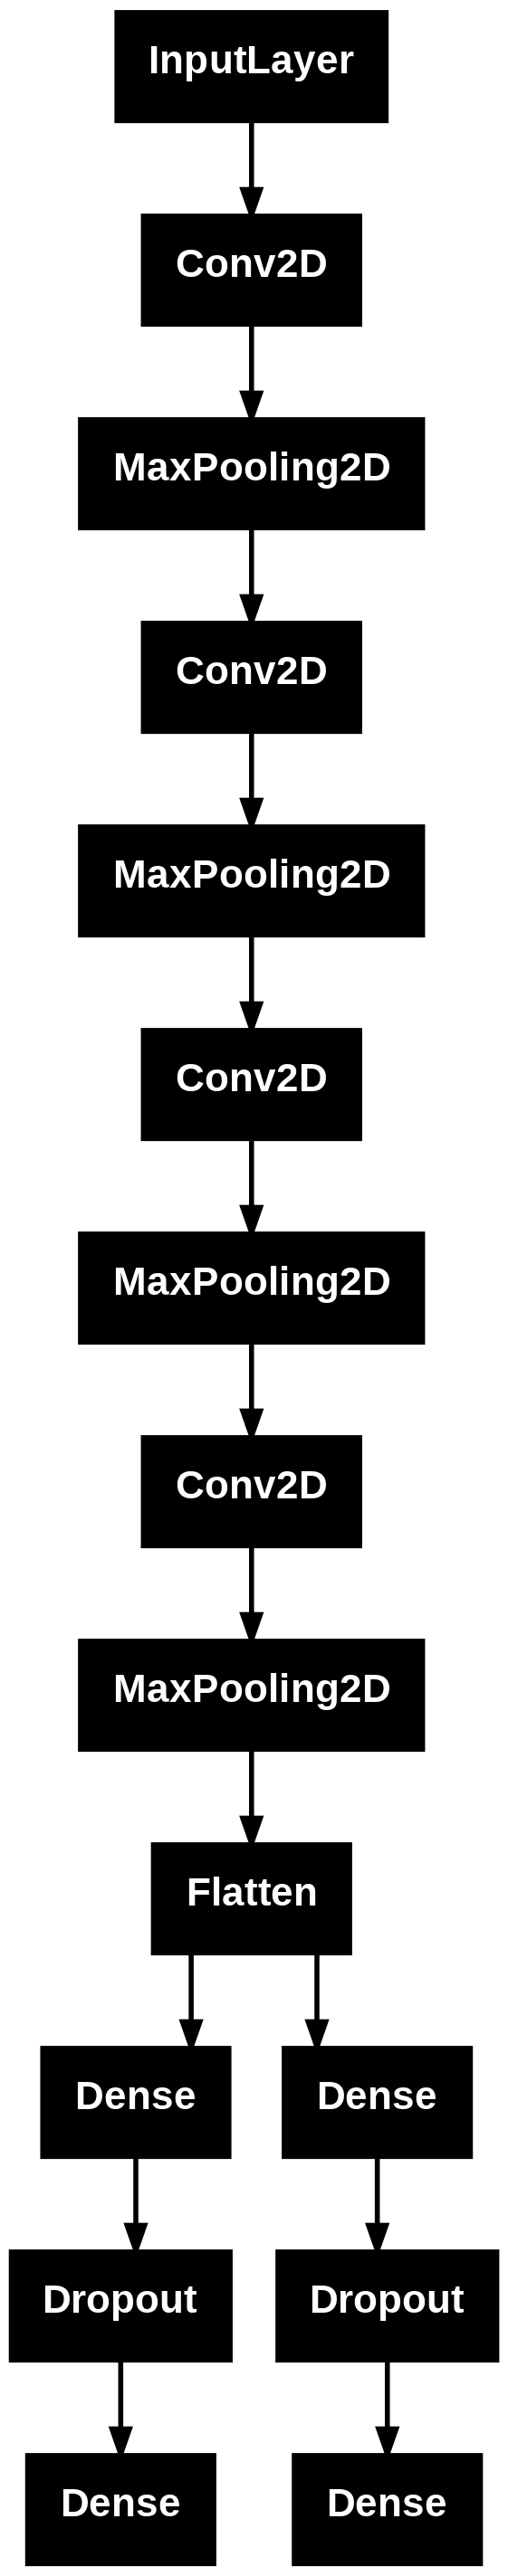

In [29]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [30]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - age_out_mae: 16.4283 - gender_out_accuracy: 0.5170 - loss: 17.1801 - val_age_out_mae: 12.2559 - val_gender_out_accuracy: 0.7111 - val_loss: 12.8223
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - age_out_mae: 11.7195 - gender_out_accuracy: 0.7359 - loss: 12.2598 - val_age_out_mae: 9.9822 - val_gender_out_accuracy: 0.7841 - val_loss: 10.4232
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - age_out_mae: 9.9800 - gender_out_accuracy: 0.7935 - loss: 10.4267 - val_age_out_mae: 8.6970 - val_gender_out_accuracy: 0.8203 - val_loss: 9.0953
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - age_out_mae: 8.9187 - gender_out_accuracy: 0.8069 - loss: 9.3301 - val_age_out_mae: 8.8600 - val_gender_out_accuracy: 0.8231 - val_loss: 9.2323
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 8.3270 - gender_out_accuracy: 0.8369 - loss: 8.6913 - val_age_out_mae: 7.5298 - val_gender_out_accuracy: 0.8484 - val_loss:

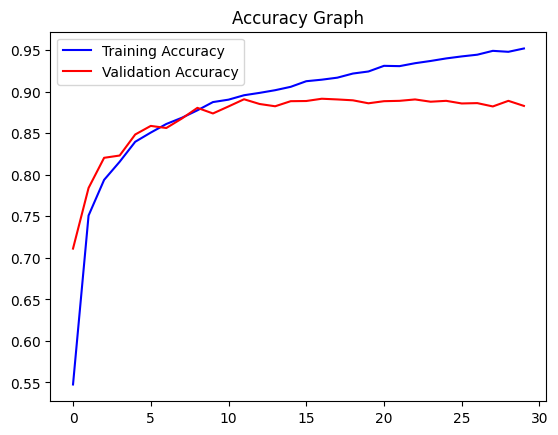

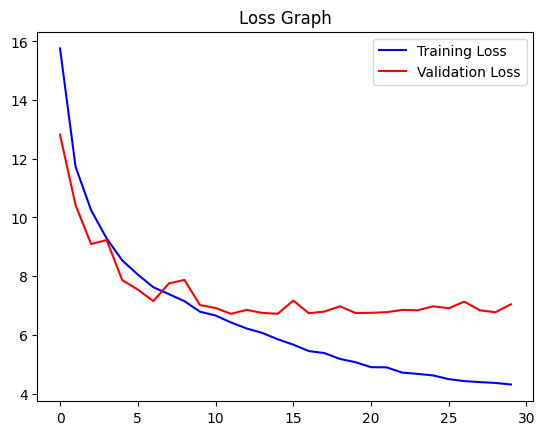

In [31]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

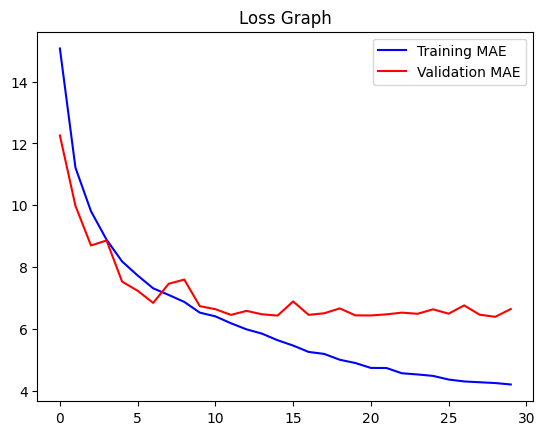

In [32]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicted Gender: Female Predicted Age: 3


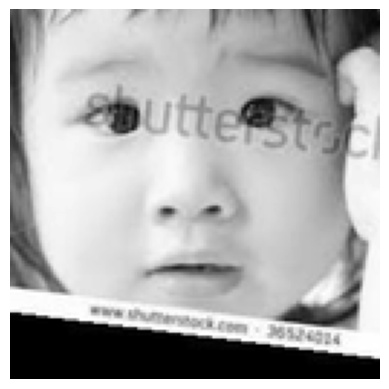

In [33]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 14


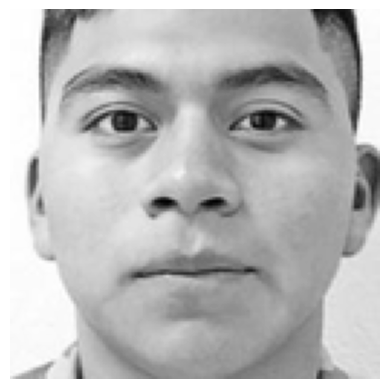

In [34]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Male Predicted Age: 36


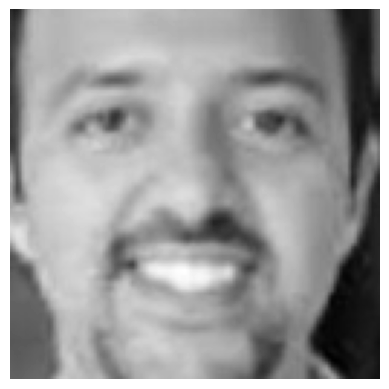

In [35]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [ ]:
# Function to preprocess a single image
def preprocess_image(image_path, target_size=(128, 128)):
    # Load and preprocess the image
    img = load_img(image_path, color_mode='grayscale')
    img = img.resize(target_size, Image.ANTIALIAS)
    img = np.array(img)
    img = img / 255.0  # Normalize if necessary
    img = img.reshape(1, target_size[0], target_size[1], 1)  # Reshape for model input
    return img

# Path to the new image
new_image_path = ''

# Preprocess the new image
new_image = preprocess_image(new_image_path)

# Predict age and gender
pred = model.predict(new_image)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender)
print("Predicted Age:", pred_age)

# Optionally, display the image
plt.axis('off')
plt.imshow(new_image.reshape(128, 128), cmap='gray')
plt.show()